In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GINConv
from torch.nn import Linear, LeakyReLU, Sequential, Dropout, BatchNorm1d
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

In [2]:
classes_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)

# Preprocess the classes DataFrame
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

# Create a mapping for all nodes
all_nodes_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

# Create edges list with all nodes
edges_list = [
    (all_nodes_dict[edges['txId1'][i]], all_nodes_dict[edges['txId2'][i]])
    for i in tqdm(range(len(edges)))
    if edges['txId1'][i] in all_nodes_dict and edges['txId2'][i] in all_nodes_dict
]
edge_index = torch.tensor(edges_list, dtype=torch.long).T

# Convert node features and labels    Parameter to (V) choose features used
#node_features = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float)
time_step = torch.tensor(df['time_step'].values, dtype=torch.float)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.iloc[:, 2:].values)  # Exclude txId and time_step

# Combine time_step back with scaled features
node_features = torch.cat((time_step.unsqueeze(1), torch.tensor(scaled_features, dtype=torch.float)), dim=1)

label_mapping = {'1': 0, '2': 1, 'unknown': -1} 
labels = torch.tensor(classes['label'].map(label_mapping).values, dtype=torch.long)

# Create graph data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 234355/234355 [00:00<00:00, 246310.41it/s]


cpu


In [3]:
'''time_step_column_index = 0 
time_step = data.x[:, time_step_column_index]

train_mask = (time_step >= 1) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

train_mask = train_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)'''

'time_step_column_index = 0 \ntime_step = data.x[:, time_step_column_index]\n\ntrain_mask = (time_step >= 1) & (time_step <= 34)\ntest_mask = (time_step >= 35) & (time_step <= 49)\n\ntrain_mask = train_mask.clone().detach().to(torch.bool)\ntest_mask = test_mask.clone().detach().to(torch.bool)'

In [4]:
train_mask = (time_step >= 1) & (time_step <= 29)
val_mask = (time_step >= 30) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

# Ensure the masks are boolean tensors
train_mask = train_mask.clone().detach().to(torch.bool)
val_mask = val_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)

In [5]:
#Hyperparameters
# embeddings length = 128
# Leaky ReLU
# lr = 0.02
# weight_decay = 0.001
# epochs = 251

embeddings_length = 128
lr = 0.0005
weight_decay = 0.001
epochs = 201

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


# Define model
class GIN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.mlp = Sequential(
            Linear(num_features, embeddings_length*2),  
            LeakyReLU(), 
            Linear(embeddings_length*2, embeddings_length)  
        )
        self.gin = GINConv(self.mlp)
        self.dropout = Dropout(p=0.3)
        self.bn = torch.nn.BatchNorm1d(embeddings_length)
        self.out = Linear(embeddings_length, num_classes)
    
    def forward(self, x, edge_index):
        h = torch.nn.functional.leaky_relu(self.gin(x, edge_index))
        h = self.bn(h)
        h = self.dropout(h)
        z = self.out(h)
        
        return h, z


# Initialize the model
num_features = data.x.shape[1]  # Number of features (columns in x)
num_classes = 2  # Number of classes (2 in this case)
model = GIN(num_features, num_classes)
model.to(device)
print(model)
print(num_classes)

# Loss function and optimizer

valid_labels = classes['label'].map(label_mapping)
valid_labels = valid_labels[valid_labels != -1]  # Exclude 'unknown'

# Convert to a PyTorch tensor for use in the loss function
class_weights_tensor = torch.tensor([0.7, 0.3], dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

def calculate_metrics(y_true, y_pred, target_class=0):
    precision = precision_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    return precision, recall, f1
val_f1_scores = []
train_f1_scores = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)  # h: embeddings, z: logits

    # Exclude unlabeled nodes from the loss calculation
    mask = data.y[train_mask] != -1  
    loss = criterion(z[train_mask][mask], data.y[train_mask][mask]) # Compute loss
    
    loss.backward()                         # Backpropagate
    optimizer.step()                        # Update model parameters

    acc = accuracy(z[train_mask].argmax(dim=1)[mask], data.y[train_mask][mask])  # Calculate accuracy
    train_precision, train_recall, train_f1 = calculate_metrics(data.y[train_mask][mask], z[train_mask].argmax(dim=1)[mask])

    model.eval() 
    with torch.no_grad():
        mask_val = data.y[val_mask] != -1  
        val_loss = criterion(z[val_mask][mask_val], data.y[val_mask][mask_val])
        val_acc = accuracy(z[val_mask].argmax(dim=1)[mask_val], data.y[val_mask][mask_val])

        val_y_true = data.y[val_mask][mask_val].cpu().numpy()
        val_y_pred = z[val_mask][mask_val].argmax(dim=1).cpu().numpy()
        val_precision, val_recall, val_f1 = calculate_metrics(val_y_true, val_y_pred)

    train_losses.append(loss.item())
    train_accuracies.append(acc.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc.item())
    val_f1_scores.append(val_f1)
    train_f1_scores.append(train_f1)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%% | F1 (Val): {val_f1:.4f}')


GIN(
  (mlp): Sequential(
    (0): Linear(in_features=166, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (gin): GINConv(nn=Sequential(
    (0): Linear(in_features=166, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
  ))
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
2
Epoch   0 | Loss: 0.73 | Acc: 52.52 | Val Loss: 0.8533 | Val Acc: 29.49%% | F1 (Val): 0.3197
Epoch  10 | Loss: 0.49 | Acc: 89.12 | Val Loss: 0.8552 | Val Acc: 83.18%% | F1 (Val): 0.0000
Epoch  20 | Loss: 0.36 | Acc: 89.08 | Val Loss: 0.5749 | Val Acc: 67.46%% | F1 (Val): 0.4282
Epoch  30 | Loss: 0.32 | Acc: 91.59 | Val Loss: 0.4735 | Val Acc: 84.97%% | F1 (Val): 0.5721
Epoch  40 | Loss: 0.29 | Acc: 91.11 |

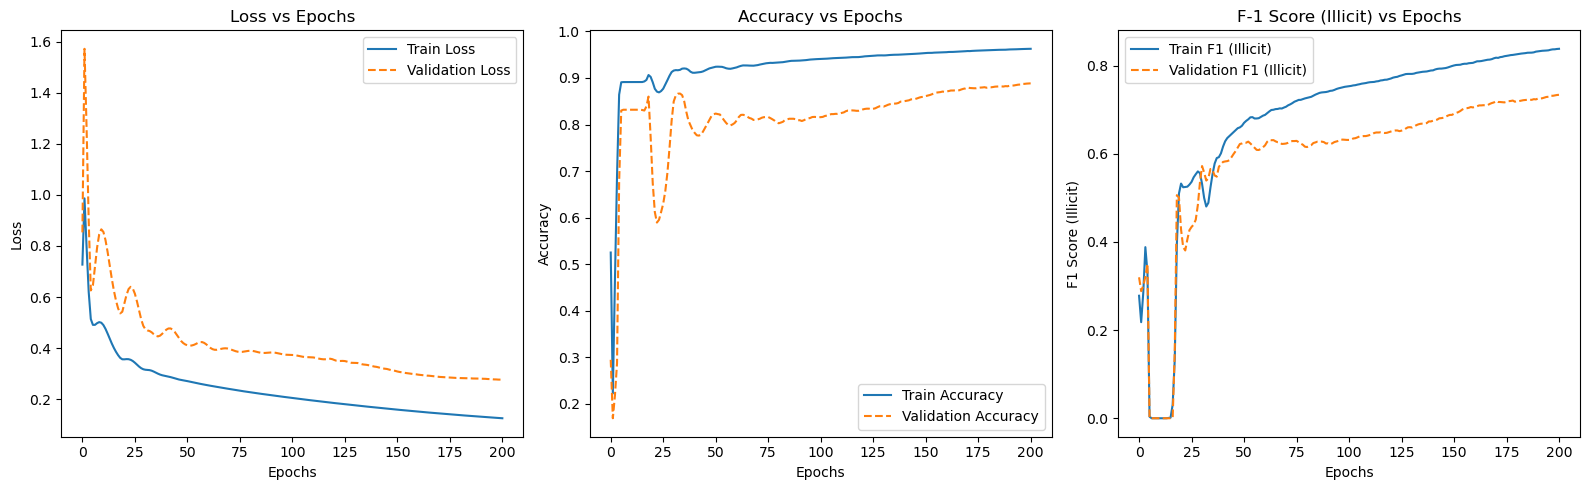

In [6]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(16, 5))

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# Plot F1
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Train F1 (Illicit)')
plt.plot(val_f1_scores, label='Validation F1 (Illicit)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Illicit)')
plt.title('F-1 Score (Illicit) vs Epochs')
plt.legend()

plt.savefig('training_gin.png', format='png', dpi=300)

plt.tight_layout()
plt.show() 

In [7]:
# Extract node embeddings
model.eval()
with torch.no_grad():
    embeddings, _ = model(data.x, data.edge_index)  # h: embeddings

# Ensure alignment of txId and labels with embeddings
# The order in `data.x` corresponds to `classes['txId']` due to how `all_nodes_dict` was built
aligned_df = pd.DataFrame({
    'txId': classes['txId'],  # Use the original node order
    'time_step': time_step.cpu().numpy(),  # Extract time_step from the GCN input
    'label': classes['label']  # Use the original labels
})

# Add embeddings
embeddings_df = pd.concat([aligned_df, pd.DataFrame(embeddings.cpu().numpy())], axis=1)

# Save to CSV
embeddings_df.to_csv('../data/embeddings_gin1.csv', index=False)


In [8]:
embeddings_df.drop(embeddings_df[embeddings_df["label"] == "unknown"].index, inplace=True)
y = embeddings_df['label']
X = embeddings_df.drop(columns=['label'])

In [9]:
X_train_gin = X[X['time_step'].between(1, 34)]
y_train_gin = y[X['time_step'].between(1, 34)]

X_test_gin = X[X['time_step'].between(35, 49)]
y_test_gin = y[X['time_step'].between(35, 49)]

X_train_gin = X_train_gin.drop(columns=['time_step','txId'])
X_test_gin = X_test_gin.drop(columns=['time_step','txId'])

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

clf_gin = RandomForestClassifier(n_estimators = 500, random_state=42)  
clf_gin.fit(X_train_gin, y_train_gin)
y_pred_gin = clf_gin.predict(X_test_gin)

precision_ilicit_gin = precision_score(y_test_gin, y_pred_gin, pos_label='1')
recall_ilicit_gin = recall_score(y_test_gin, y_pred_gin, pos_label='1')
f1_ilicit_gin = f1_score(y_test_gin, y_pred_gin, pos_label='1')
f1_scorer_gin = make_scorer(f1_score, pos_label='1')
scores_gin = cross_val_score(clf_gin, X_train_gin, y_train_gin, cv=5, scoring=f1_scorer_gin)

print(f'Precision node embeddings (GIN): {precision_ilicit_gin}')
print(f'Recall node embeddings (GIN): {recall_ilicit_gin}')
print(f'F1 node embeddings (GIN): {f1_ilicit_gin}')
print("Cross-validated F1 Score node embeddings (GIN):", scores_gin.mean())

Precision node embeddings (GIN): 0.6939571150097466
Recall node embeddings (GIN): 0.32871652816251157
F1 node embeddings (GIN): 0.44611528822055135
Cross-validated F1 Score node embeddings (GIN): 0.6930211500920225
